# High-NA vectorial PSF generation

In [1]:
from typing import Optional, Tuple

import flax.linen as nn
import matplotlib.pyplot as plt
import numpy as np
from jax import random

from chromatix.elements import (
    FFLens2,
    GaussianSource,
)

key = random.PRNGKey(42)


%load_ext autoreload
%autoreload 2

In [72]:
class HighNAPSF(nn.Module):
    ansi_indices = np.arange(1, 11)
    camera_shape: Tuple[int, int] = (256, 256)
    pupil_shape: Tuple[int, int] = (256, 256)
    camera_pixel_pitch: float = 0.125
    f: float = 100
    NA: float = 1.3
    n: float = 1.5
    wavelength: float = 0.532
    wavelength_ratio: float = 1.0
    upsample: int = 4
    pad: int = 128
    taper_width: Optional[float] = 5

    @nn.compact
    def __call__(self):
        # Some preliminaries
        shape = tuple(np.array(self.camera_shape) * self.upsample + self.pad)
        spacing = (
            self.upsample
            * self.f
            * self.wavelength
            / (self.n * shape[0] * self.camera_pixel_pitch)
        )
        field = GaussianSource(
            self.pupil_shape,
            spacing,
            self.wavelength,
            self.wavelength_ratio,
            self.f,
            self.n,
            self.NA,
            power=1e7,
            amplitude=np.array([0.0, 0.0, 1.0]),
            scalar=False,
            envelope_waist=1,
        )(z=0)

        field = FFLens2(
            self.NA, self.camera_shape, self.camera_pixel_pitch, self.wavelength
        )(field)
        return field

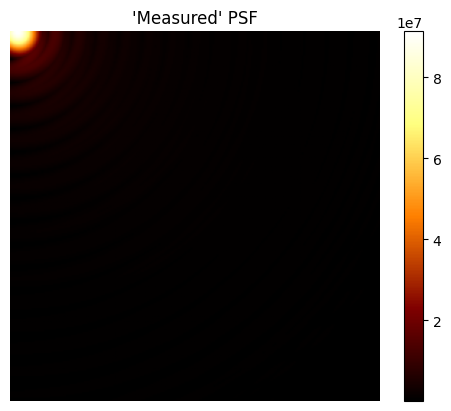

In [82]:
# Initialize model
model = HighNAPSF()
variables = model.init(key)
state = variables["state"]
del variables  # delete for memory

# Generating data
output_field = model.apply({"state": state})
psf_truth = np.abs(output_field).sum(axis=-1)
# psf_truth = np.fft.fftshift(np.abs(output_field).sum(axis=-1))

plt.figure()
plt.imshow(psf_truth.squeeze(), cmap="afmhot")
plt.colorbar()
plt.title("'Measured' PSF")
plt.axis("off")
plt.show()